## IMPORTS

In [1]:
import numpy as np
import csv
import cv2
from matplotlib import pyplot as plt
from random import sample
import random

from keras.models import Sequential
from keras.layers import Flatten,Dense,Dropout,Lambda
from keras.layers.advanced_activations import ELU
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.regularizers import l2


print('imported')

Using TensorFlow backend.


imported


In [14]:
lines=[]
s_angles=[]
images=[]
with open('driving_log.csv') as mfile:
	reader=csv.reader(mfile)
	for line in reader:
		lines.append(line)

for line in lines:
	s_angles.append(float(line[3]))
	imname=line[0].split('\\')[-1]
	path='IMG\\'+imname
	img=cv2.imread(imname)
	images.append(img)
    
x_train=np.array(images)
y_train=np.array(s_angles)

print('# of frames:',len(x_train ))


# of frames: 8336


In [3]:
#OK_TODO: histogram bins of angles
#OK_TODO: Flip augment
#TODO: brightness adjust
#OK_TODO: remove 0 which dominates
#TODO: create model possibly with inceptions

## PREPROCESSING

In [16]:
def preprocess(imageset):
	processed=[]
	for img in imageset:
		cropped=img[70:140,:,:]
		blurred=cv2.GaussianBlur(cropped,(3,3),0)
		

		img_yuv = cv2.cvtColor(blurred, cv2.COLOR_BGR2YUV)

    # equalize the histogram of the Y channel
		img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

    # convert the YUV image back to RGB format
		img= cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
		img=img[...,::-1] #bgr 2 rgb

		processed.append(img_yuv)
	return processed

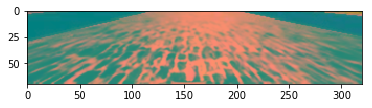

In [18]:
x_train_p=preprocess(x_train)

x_train_p_zeros=[]
x_train_p_turns=[]
y_train_zeros=[]
y_train_turns=[]
for i in range(len(y_train)):
    crit=0.2
    if abs(y_train[i])<crit:
        if random.random()<crit/2:
            x_train_p_zeros.append(x_train_p[i])
            y_train_zeros.append(y_train[i])
    else:
        x_train_p_turns.append(x_train_p[i])
        y_train_turns.append(y_train[i])
#assert(len(y_train)==len(y_train_zeros)+len(y_train_turns))
plt.imshow(x_train_p[0])
plt.show()

## DATA AUGMENTATION

2571 2571


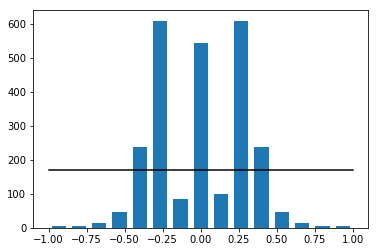

In [20]:
def flip(imageset,angleset):
    new_img_set=[]
    new_ang_set=[]
    for i in range(len(imageset)):
        newimg=cv2.flip(imageset[i],1)
        new_img_set.append(newimg)
        new_ang_set.append(-angleset[i])
    return new_img_set,new_ang_set

def brightnes_adjust(imageset,angleset):
    new_img_set=[]
    new_ang_set=[]
    for i in range(len(imageset)):
        newimg=cv2.flip(imageset[i],1)
        new_img_set.append(newimg)
        new_ang_set.append(-angleset[i])
    return new_img_set,new_ang_set

new_flipped_imset,new_angset=flip(x_train_p_turns,y_train_turns)

x_train_f=np.concatenate((x_train_p_zeros,x_train_p_turns,new_flipped_imset),axis=0)
y_train_f=np.concatenate((y_train_zeros,y_train_turns,new_angset),axis=0)

print(len(x_train_f),len(y_train_f))

num_bins = 15
avg_samples_per_bin = len(y_train_f)/num_bins
hist, bins = np.histogram(y_train_f, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(y_train_f), np.max(y_train_f)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()


## MODEL ARCHITECTURE

In [21]:
model = Sequential()

# Normalize
model.add(Lambda(lambda x: x/255 - 0.5,input_shape=(70,320,3)))

# Add three 5x5 convolution layers (output depth 24, 36, and 48), each with 2x2 stride
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode='valid', W_regularizer=l2(0.001)))
model.add(ELU())
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='valid', W_regularizer=l2(0.001)))
model.add(ELU())
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode='valid', W_regularizer=l2(0.001)))
model.add(ELU())

#model.add(Dropout(0.50))

# Add two 3x3 convolution layers (output depth 64, and 64)
model.add(Convolution2D(64, 3, 3, border_mode='valid', W_regularizer=l2(0.001)))
model.add(ELU())
model.add(Convolution2D(64, 3, 3, border_mode='valid', W_regularizer=l2(0.001)))
model.add(ELU())

# Add a flatten layer
model.add(Flatten())

# Add three fully connected layers (depth 100, 50, 10), tanh activation (and dropouts)
model.add(Dense(150, W_regularizer=l2(0.001)))
model.add(ELU())
#model.add(Dropout(0.50))
model.add(Dense(70, W_regularizer=l2(0.001)))
model.add(ELU())
#model.add(Dropout(0.50))
model.add(Dense(10, W_regularizer=l2(0.001)))
model.add(ELU())
#model.add(Dropout(0.50))

# Compile and train the model, 
#model.compile('adam', 'mean_squared_error')
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')
model.fit(x_train_f,y_train_f,validation_split=0.2,shuffle=True,nb_epoch=25)
model.save('model.h5')

C:\Users\talha\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), kernel_regularizer=<keras.reg..., padding="valid", strides=(2, 2))`
  import sys
C:\Users\talha\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), kernel_regularizer=<keras.reg..., padding="valid", strides=(2, 2))`
  if __name__ == '__main__':
C:\Users\talha\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), kernel_regularizer=<keras.reg..., padding="valid", strides=(2, 2))`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\talha\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="valid")`
C:\Users\talha\Anaconda3\lib\site-packages\ipykernel_l

Train on 2056 samples, validate on 515 samples
Epoch 1/25
2056/2056 [==============================] - 6s - loss: 0.6022 - val_loss: 0.5109
Epoch 2/25
2056/2056 [==============================] - 4s - loss: 0.4093 - val_loss: 0.3854
Epoch 3/25
2056/2056 [==============================] - 4s - loss: 0.3044 - val_loss: 0.2925
Epoch 4/25
2056/2056 [==============================] - 4s - loss: 0.2381 - val_loss: 0.2564
Epoch 5/25
2056/2056 [==============================] - 4s - loss: 0.1927 - val_loss: 0.1988
Epoch 6/25
2056/2056 [==============================] - 4s - loss: 0.1596 - val_loss: 0.1772
Epoch 7/25
2056/2056 [==============================] - 4s - loss: 0.1318 - val_loss: 0.1474
Epoch 8/25
2056/2056 [==============================] - 4s - loss: 0.1127 - val_loss: 0.1271
Epoch 9/25
2056/2056 [==============================] - 4s - loss: 0.1006 - val_loss: 0.1391
Epoch 10/25
2056/2056 [==============================] - 4s - loss: 0.0910 - val_loss: 0.1076
Epoch 11/25
2056/2056 

In [22]:
#model.save_weights('model.h5')
model.save('model.h5')
json_string = model.to_json()
with open('model.json', 'w') as f:
      f.write(json_string)
print('saved')

saved
